In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import itertools
from collections import Counter

# load and preprocess

In [2]:
df = pd.read_excel("sensitive_data/workforce_data.xlsx")
for col in ["Ausbildung", "Erfahrung", "Schlüsselqualifikation"]:
    df[col].fillna("", inplace=True)

In [3]:
# the features we are interested in
features = ["Kenntnisse", "Schlüsselqualifikation", "Software", "Erfahrung"]
feature_colors = ["red", "green", "blue", "yellow"]

In [4]:
#get all possible values for all features
values = {}
for f in features:
    # get all possible values for this feature
    values["feature_%s" % f] = set(itertools.chain(*[["feature_%s_value_%s" % (f, v.strip()) for v in value.split(';') if len(v.strip())] for value in df[f].tolist()]))

In [5]:
# count how many people have that skill
value_counter = Counter(
    [
        "feature_%s_value_%s" % (f, v.strip()) 
        for f in features
        for value in df[f].tolist()
        for v in value.split(';')
    ]
)

In [6]:
values

{'feature_Kenntnisse': {'feature_Kenntnisse_value_CAD-Kenntnisse',
  'feature_Kenntnisse_value_CNC-Kenntnisse',
  'feature_Kenntnisse_value_Digitalisierung / Industrie 4.0',
  'feature_Kenntnisse_value_Dübeltechnik',
  'feature_Kenntnisse_value_EN13849 Sicherheitstechnik',
  'feature_Kenntnisse_value_ERP-Kenntnisse',
  'feature_Kenntnisse_value_Englischkenntnisse',
  'feature_Kenntnisse_value_Erste Hilfe-Kenntnisse',
  'feature_Kenntnisse_value_Festigkeit (FEA)',
  'feature_Kenntnisse_value_Fremdsprachenkenntnisse Spanisch',
  'feature_Kenntnisse_value_Führerschein lauf- und flurgesteuerte Kräne',
  'feature_Kenntnisse_value_Grundkenntnisse im Schweißen',
  'feature_Kenntnisse_value_Hebe- und Arbeitsbühnenführerschein',
  'feature_Kenntnisse_value_Interne Sicherheit',
  'feature_Kenntnisse_value_Kenntnisse Mechatronik',
  'feature_Kenntnisse_value_Kenntnisse NC-Technik',
  'feature_Kenntnisse_value_Kenntnisse Oberflächenbehandlung',
  'feature_Kenntnisse_value_Kenntnisse Persönlichkeit

# build graph
- treat clustering problem as minimal closed set problem (with soft constraints)
- transform to s-t cut problem
- use minimum cut to solve

In [7]:
g = nx.Graph()
node_color = []

# target nodes
seniorities = ["sc_0", "sc_1"]
g.add_node(seniorities[0], layer=0)
node_color.append('black')

g.add_node(seniorities[1], layer=3)
node_color.append('black')

# feature value nodes (i.e. the skills)
for feature_color, (f, v) in zip(feature_colors, values.items()):
    for vl in v:
        node_color.append(feature_color)
        g.add_node(vl, layer=2)
        g.add_edge(seniorities[1], vl, capacity=1)        
        

# add each person, connect each person to its skills
for idx, person in df.iterrows():
    person_id = "person_%d" % idx
    g.add_node(person_id, layer=1)
    node_color.append('magenta')

    g.add_edge(person_id, seniorities[0], capacity=1)

    for f in features:
        values_of_person = [v.strip() for v in person[f].split(';') if len(v.strip())]
        for v in values_of_person:
            value_node = "feature_%s_value_%s" % (f, v.strip())
            # add edge of person to skill, but weighted by 'uniqueness' of skill
            g.add_edge(person_id, value_node, capacity=1/value_counter[value_node])            

    
residual, (sen_0, sen_1) = nx.algorithms.flow.minimum_cut(g, seniorities[0], seniorities[1])

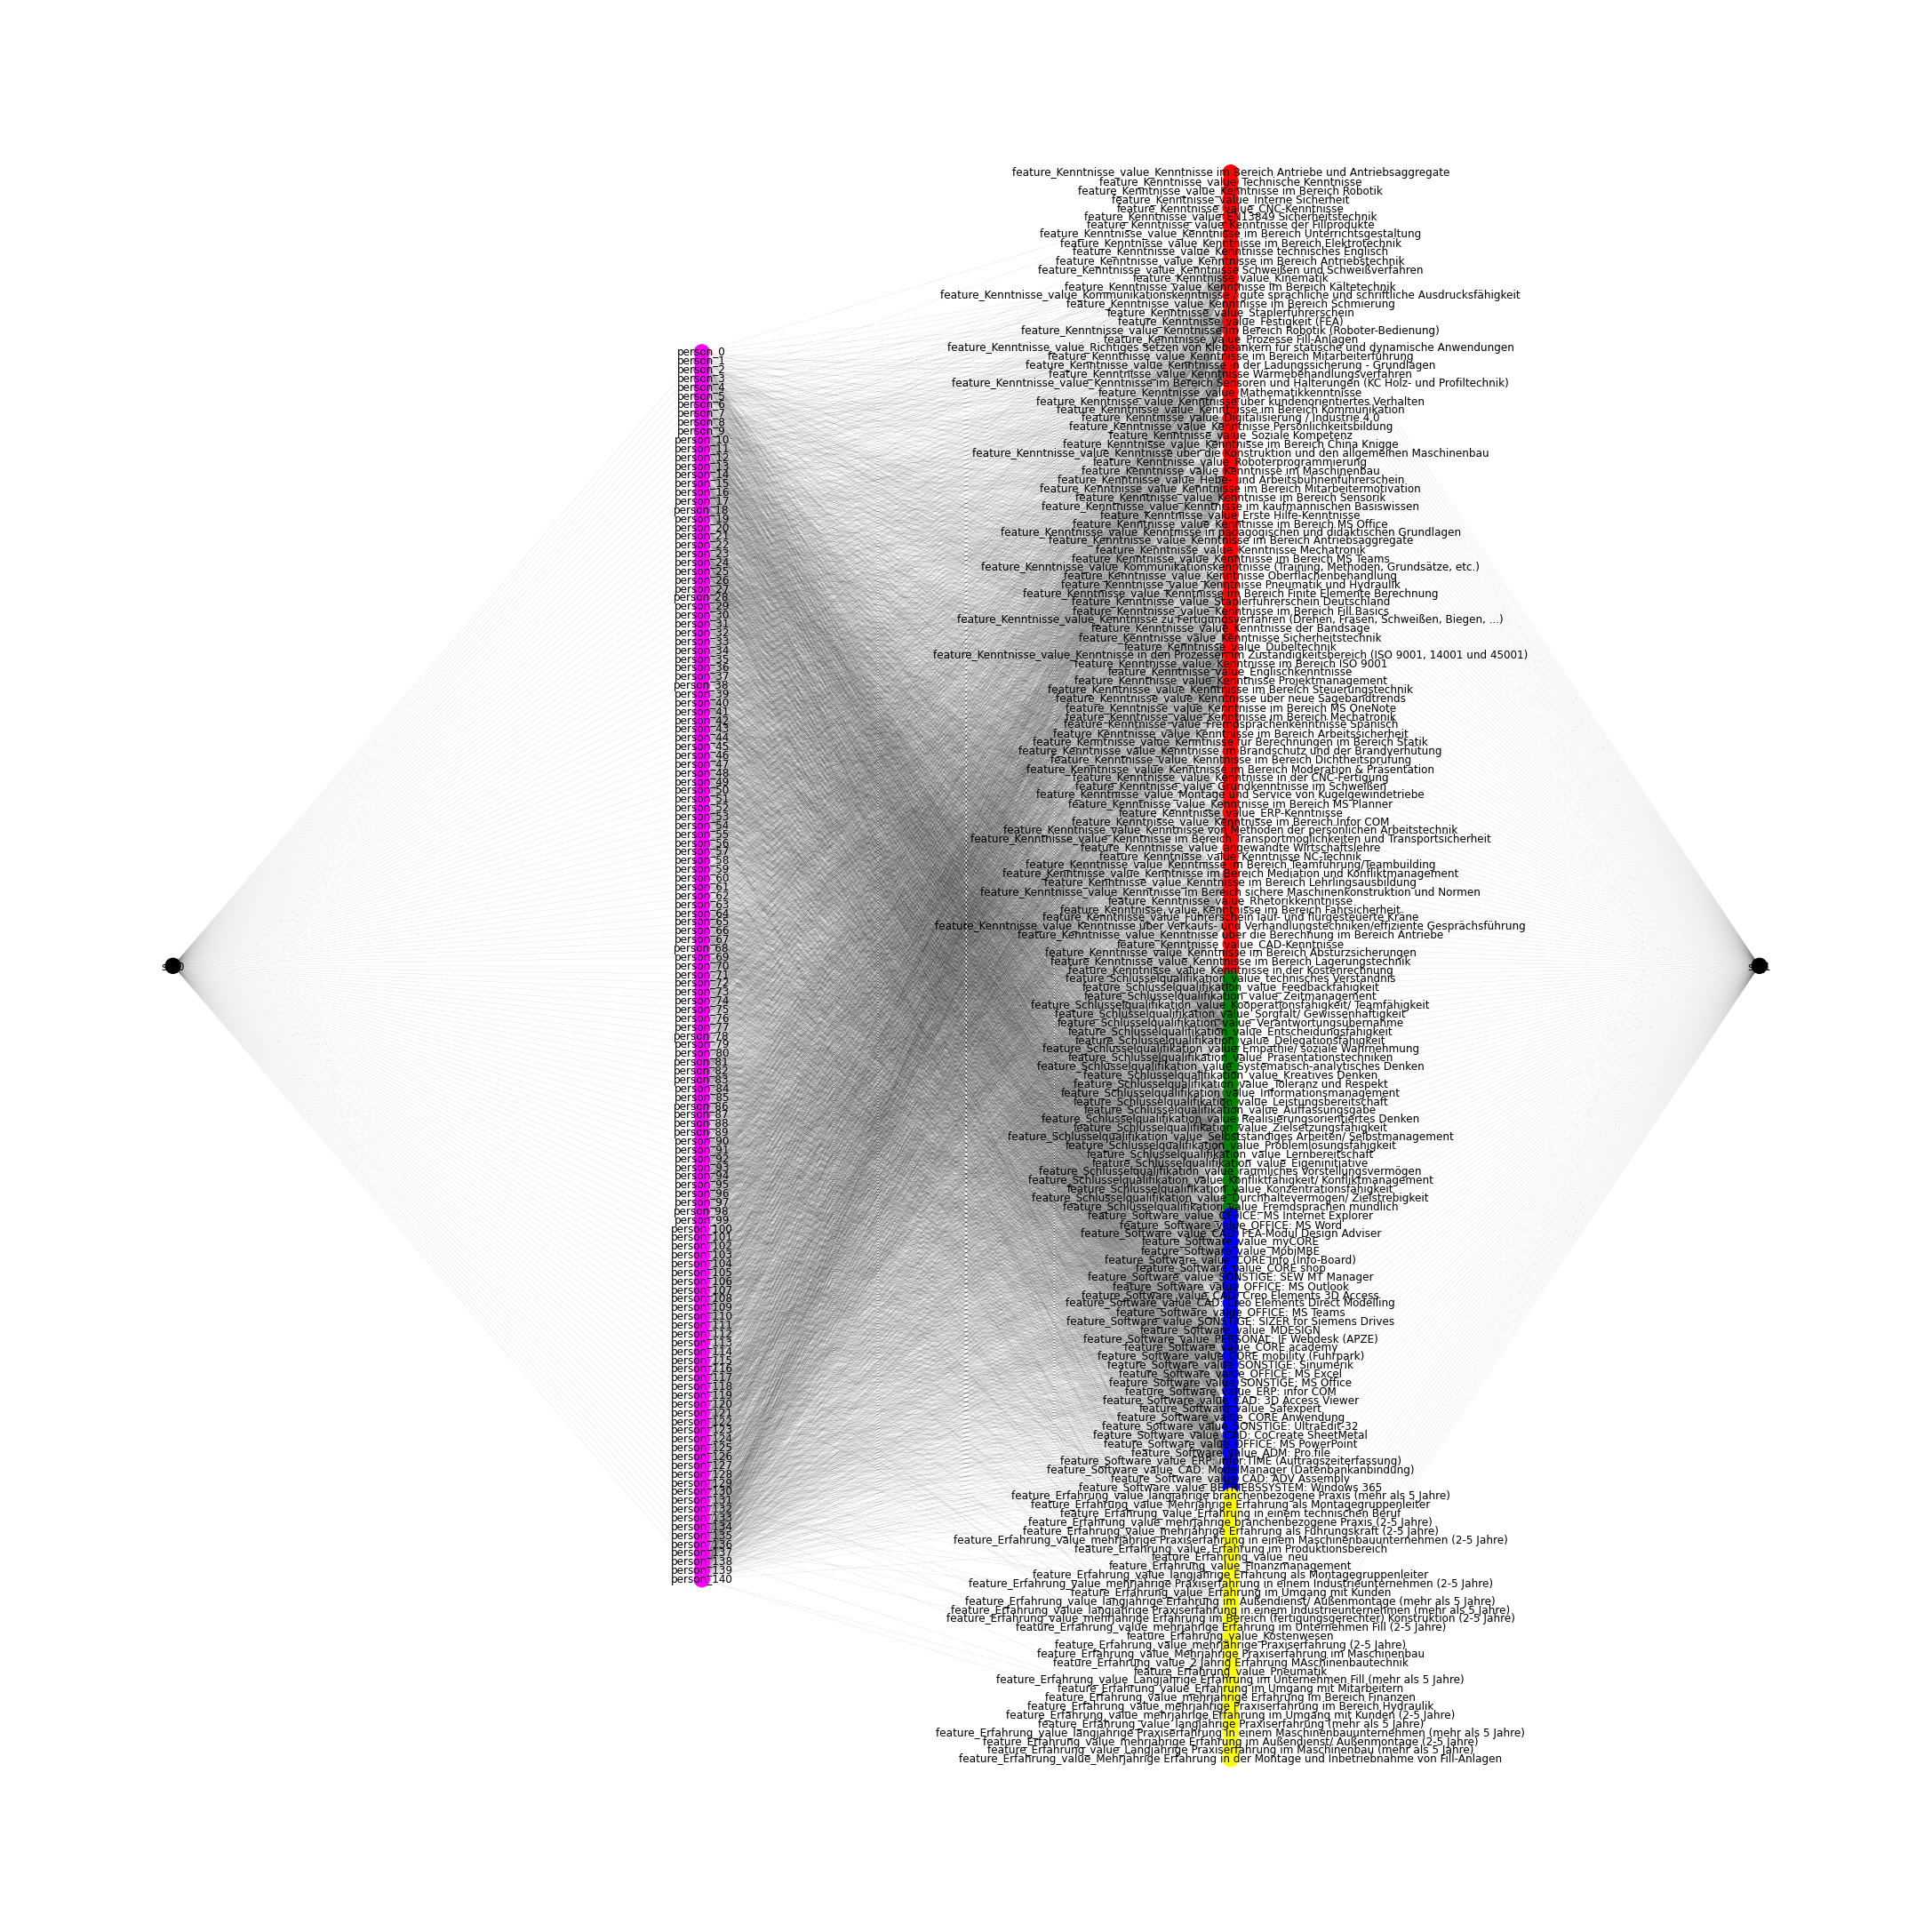

In [8]:
plt.figure(figsize=(30,30))
pos = nx.multipartite_layout(g, subset_key="layer")
nx.draw(g, pos, with_labels=True, node_color=node_color, width=0.05)

In [9]:
# iff the person is in the second partition of the graph, set it's seniority_cluster to sc_1
df['seniority_cluster'] = 'sc_0'
for idx, person in df.iterrows():
    person_id = "person_%d" % idx
    if person_id in sen_1:
        df.at[idx, 'seniority_cluster'] = 'sc_1'

In [10]:
cluster_data = df.groupby('seniority_cluster').Position.value_counts()
cluster_data

seniority_cluster  Position               
sc_0               Maschinenbautechnik        57
                   Montagegruppenleitung 2    28
                   Montagegruppenleitung 1     2
sc_1               Montagegruppenleitung 2    23
                   Montagegruppenleitung 1    18
                   Maschinenbautechnik        13
Name: Position, dtype: int64

C:\Users\mrnocker\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


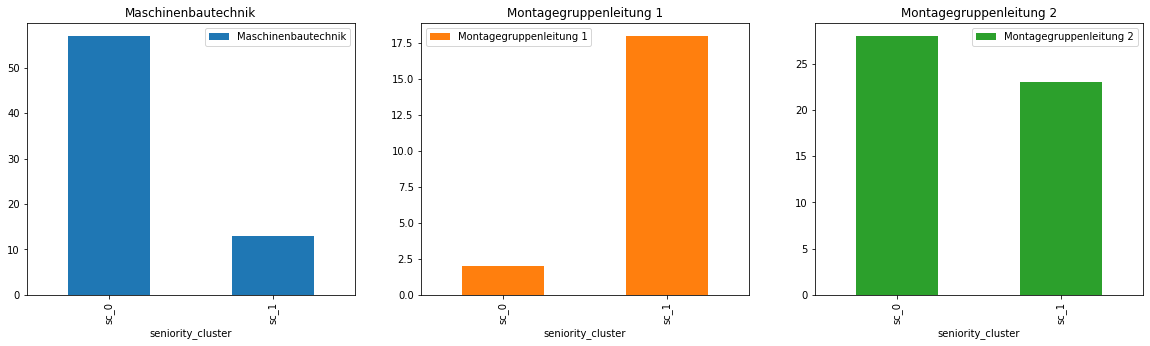

In [11]:
fig = plt.figure(figsize=(20, 5))
cluster_data.sort_index().unstack().plot(kind='bar', subplots=True, layout=(1,3), ax=plt.gca());